In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy import stats
import seaborn as sns

In [3]:
'''
se define el indice Datetime para eliminar las columnas referentes a las fechas
de las erupciones y su hora de inicio. ademas se calculan las energias pasando 
los valores de la columna energy.KeV a dos valores float.
'''
file_path = r"C:\Python\HessiSolarFlare2018.csv"  #2002to2018.csv
df = pd.read_csv(file_path)
formatT = '%Y-%m-%d %H:%M:%S'
df['Datetime'] = pd.to_datetime(df['start.date'] + ' ' + df['start.time'], format=formatT)
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
df = df.drop(columns=['start.date', 'start.time', 'Datetime'])
Emin = []
Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Emin.append(float(result[0]))
    Eprom.append((float(result[0]) + float(result[1]))/2)
df['EnergiaMin']=Emin
df['EnergiaMax']=Emax
df['EnergiaProm']=Eprom
'''
Tomamos todas las banderas flags y las unimos en una sola columna llamada Flags
'''
df=df.fillna(value="")
df["Flags"]=df["flag.1"]+" "+df["flag.2"]+" "+df["flag.3"]+" "+df["flag.4"]\
+" "+df["flag.5"] 
for i in range (1,6): del df["flag."+str(i)]
'''
Hago un calculo de las freciencias de la energia Promedio, Aunque por ahora
no es muy pertinente para el analisis, tal vez si pueda hacerse algo después.
plank=4.135667696*pow(10,-15)
vluz=3*pow(10,8)
Frec=[]
long=[]
for i in df['EnergiaProm']:
    Frec.append(i/plank)
    long.append(vluz/(i/plank))
df['Frec']=Frec
df['Long']=long
'''
'''funcion filtro recibe un dataframe una columna del mismo (un string),
y una condición, retorna un dataframe filtrado por el condicional 
''' 
def Filtro(df,col,cond):
    a=df[col] == cond
    dfa=df[a]
    return dfa  


{'whiskers': [<matplotlib.lines.Line2D at 0x1ba316b8280>,
 'caps': [<matplotlib.lines.Line2D at 0x1ba316b8820>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ba316e3f70>],
 'medians': [<matplotlib.lines.Line2D at 0x1ba316b8dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ba316b9090>],
 'means': []}

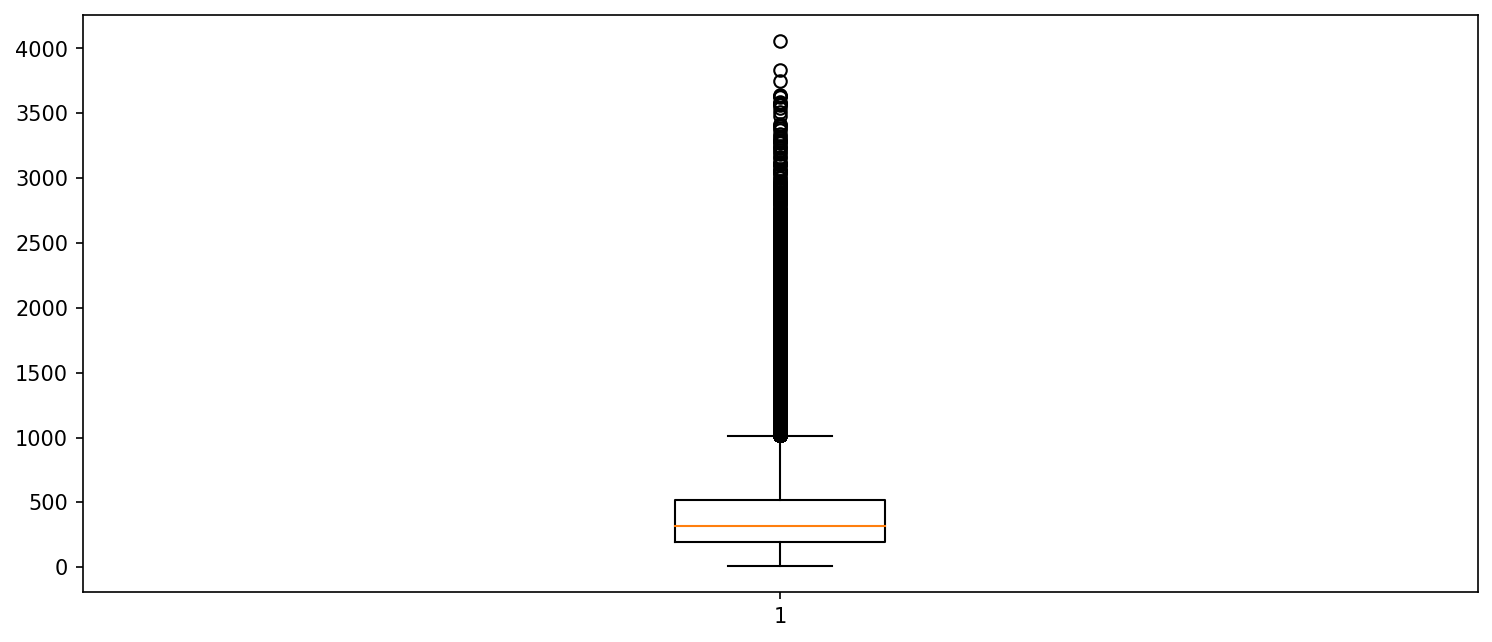

In [6]:
#graficas y analisis de datos
'''hipotesis estadistica de eventos solares filtrados por rangos de energia"""
se filtran los datos con respecto al rango de las energias presentes 
en esas erupciones
'''
#df['energy.kev'].value_counts()
energy1 = Filtro(df,'energy.kev','6-12') # Se filtra por rango de energias
energy2 = Filtro(df,'energy.kev','12-25')
energy3 = Filtro(df,'energy.kev','25-50')
energy4 = Filtro(df,'energy.kev','50-100')
datos3 = energy3['duration.s'] 
datos1 = energy1['duration.s']
datos2 = energy2['duration.s']
datos4 = energy4['duration.s']
'''diagrama de caja y bigote para la duracion 
de las eripciones con respecto a los rangos de energia'''
plt.figure(figsize=(12,5), dpi = 150)
#plt.boxplot(datos)
plt.boxplot(datos1)
#energy1.describe()

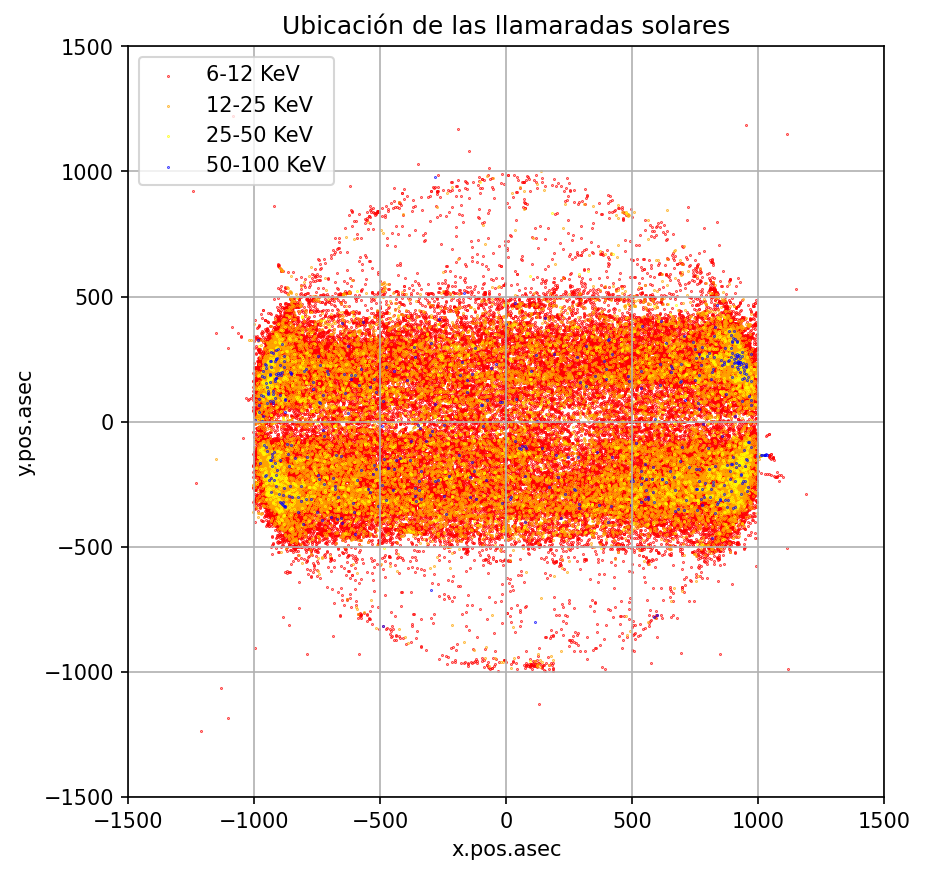

In [5]:
'''
scatter de las posiciones x.pos.asec y y.pos.asec
de cada rango de energias mayores al rango 3-6 kev
probablamente mejor con un cmap
'''
plt.figure(figsize=(6.5,6.5), dpi = 150, edgecolor='black')
plt.xlim(-1500,1500)
plt.ylim(-1500,1500)
plt.grid()
plt.title('Ubicación de las llamaradas solares')
plt.ylabel('y.pos.asec')
plt.xlabel('x.pos.asec')
plt.scatter(energy1['x.pos.asec'], energy1['y.pos.asec'],s=0.1, color='red', label='6-12 KeV')
plt.scatter(energy2['x.pos.asec'], energy2['y.pos.asec'],s=0.1, color='orange',label='12-25 KeV')
plt.scatter(energy3['x.pos.asec'], energy3['y.pos.asec'],s=0.1, color='yellow',label='25-50 KeV')
plt.scatter(energy4['x.pos.asec'], energy4['y.pos.asec'],s=0.1, color='blue', label='50-100 KeV')
plt.legend()

$$
 \textbf{grafica de la posición de las erupciones clasificada por sus energias}
$$

$$
\textbf{Matriz de correlación}
$$

<AxesSubplot:title={'center':'Mapa de calor con respecto \n a la correlación de la base de datos'}>

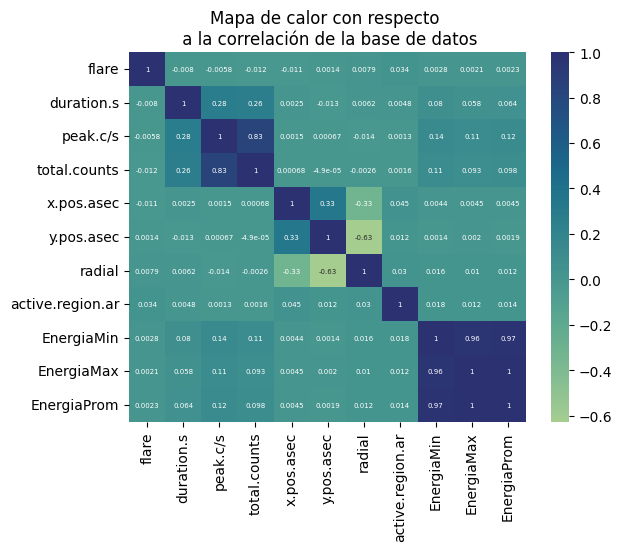

In [7]:
'''se trabaja un mapa de calor para la 
   matriz  de correlación'''
matriz=df.corr(method='pearson',numeric_only=float)
plt.title('Mapa de calor con respecto \n a la correlación de la base de datos')
sns.heatmap(matriz,cmap='crest',annot=True,
           annot_kws={'fontsize':5})